In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import Precision, Recall

In [2]:
# Function to load and preprocess image using Keras
def load_and_preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    return img_array

# Function to extract image paths from a folder
def extract_image_paths(root_folder, folder):
    image_paths = []
    for subdir, _, files in os.walk(os.path.join(root_folder, folder)):
        for file in files:
            if file.lower().endswith('.jpg'):
                image_path = os.path.join(subdir, file)
                image_paths.append(image_path)
    return image_paths

# Replace these paths with your actual dataset folder and subfolders
root_folder_path = "Reduced_Dataset"
real_folder = "Real"
fake_folder = "Fake"

In [3]:
# Extract image paths for real and fake images
real_image_paths = extract_image_paths(root_folder_path, real_folder)
fake_image_paths = extract_image_paths(root_folder_path, fake_folder)

In [4]:
# Create labels (0 for real, 1 for fake)
real_labels = np.full(len(real_image_paths), "Real")
fake_labels = np.full(len(fake_image_paths), "Fake")

In [5]:
# Combine real and fake data
X = np.concatenate([real_image_paths, fake_image_paths], axis=0)
y = np.concatenate([real_labels, fake_labels], axis=0)
df = pd.DataFrame({'Image_Path': X, 'Nature': y})
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(df.tail())

                                              Image_Path Nature
21384  Reduced_Dataset\Fake\01_11__meeting_serious__F...   Fake
21385  Reduced_Dataset\Fake\01_26__outside_talking_pa...   Fake
21386  Reduced_Dataset\Real\14__walk_down_hall_angry....   Real
21387  Reduced_Dataset\Real\03__hugging_happy.mp4\fra...   Real
21388  Reduced_Dataset\Fake\03_09__outside_talking_st...   Fake


In [6]:
target_size = (224, 224)

# Create an ImageDataGenerator for real and fake images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

# Create a flow_from_dataframe generator for training
train_generator = train_datagen.flow_from_dataframe(
    df,
    x_col='Image_Path',
    y_col='Nature',
    target_size=target_size,
    batch_size=8,
    class_mode='binary',
    subset='training'
)

# Create a flow_from_dataframe generator for validation
validation_generator = train_datagen.flow_from_dataframe(
    df,
    x_col='Image_Path',
    y_col='Nature',
    target_size=target_size,
    batch_size=8,
    class_mode='binary',
    subset='validation'
)



Found 17112 validated image filenames belonging to 2 classes.
Found 4277 validated image filenames belonging to 2 classes.


CheckPoint added

In [7]:
# # Check if GPU is available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TensorFlow")

print(tf.config.list_physical_devices('GPU'))

    
# Hyperparameters
patience = 4  # Stop training if accuracy doesn't improve
min_delta = 0.001  # Minimum tolerable difference in accuracy
filepath = "best_model_{epoch:02d}-{val_accuracy:.4f}.h5"

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes),y=train_generator.classes)

# Convert class weights to dictionary format
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Build and compile the ResNet model
with tf.device('/GPU:0'):  # Ensure model is built on GPU
    resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    resnet_model.trainable = True

    model = Sequential([
        resnet_model,
        GlobalAveragePooling2D(),
        Flatten(),
        Dense(512, activation='relu'),  # Adding a dense layer
        Dropout(0.5),  # Adding dropout for regularization
        Dense(1, activation='sigmoid')
    ])
    model.summary()


Default GPU Device: /device:GPU:0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)     

In [8]:
layers = [(layer.name, layer.trainable) for layer in model.layers]
df = pd.DataFrame(layers, columns=['Layer Name', 'Layer Trainable'])
pd.set_option('display.max_rows', None)
print(df)

                 Layer Name  Layer Trainable
0                  resnet50             True
1  global_average_pooling2d             True
2                   flatten             True
3                     dense             True
4                   dropout             True
5                   dense_1             True


In [9]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

In [10]:
# callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=patience, min_delta=min_delta, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001, verbose=1)

HistoryModel = None

# Train the model
with tf.device('/GPU:0'):  # Ensure training is done on GPU
    history = model.fit(
        train_generator,
        epochs=50,  # Increase the number of epochs
        validation_data=validation_generator,
        callbacks=[early_stopping, model_checkpoint, reduce_lr],
        class_weight=class_weights_dict,
        verbose=1
    )
    HistoryModel = history

model.save('trained_resnet_model_real_fake_Optimized.h5')

Epoch 1/50
2139/2139 [==============================] - ETA: 0s - loss: 0.6102 - accuracy: 0.6972 - precision: 0.7054 - recall: 0.6613
Epoch 1: val_accuracy improved from -inf to 0.53846, saving model to best_model_01-0.5385.h5
2139/2139 [==============================] - 694s 312ms/step - loss: 0.6102 - accuracy: 0.6972 - precision: 0.7054 - recall: 0.6613 - val_loss: 1.2138 - val_accuracy: 0.5385 - val_precision: 0.9126 - val_recall: 0.0786 - lr: 0.0010
Epoch 2/50
2139/2139 [==============================] - ETA: 0s - loss: 0.4387 - accuracy: 0.8052 - precision: 0.8130 - recall: 0.7850
Epoch 2: val_accuracy improved from 0.53846 to 0.77017, saving model to best_model_02-0.7702.h5
2139/2139 [==============================] - 592s 277ms/step - loss: 0.4387 - accuracy: 0.8052 - precision: 0.8130 - recall: 0.7850 - val_loss: 0.4886 - val_accuracy: 0.7702 - val_precision: 0.7113 - val_recall: 0.9045 - lr: 0.0010
Epoch 3/50
2139/2139 [==============================] - ETA: 0s - loss: 0.375

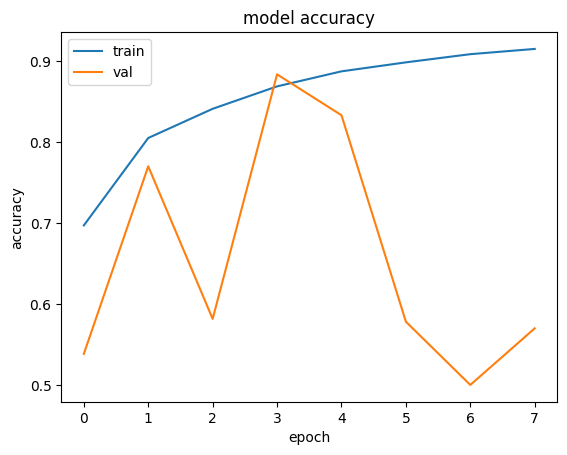

In [11]:
import keras
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

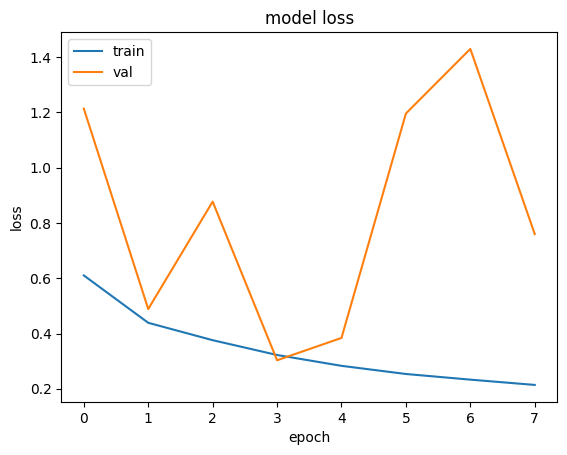

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
# Define paths to your data
test_data_dir = "Testing"  # Replace with your testing data path
# Define image dimensions (assuming you used these during training)
img_height, img_width = 224, 224
# Load your trained ResNet50 model
model = load_model("Best/best_model_21-0.9390.h5")
# Define data generators for testing
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=8,  # Adjust batch size as needed
    class_mode='binary'  # Adjust class mode based on your task (e.g., 'binary' for 2 classes)
)
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
# Print the test accuracy
print(f"Test Accuracy: {test_acc:.4f}")
# Additional analysis (optional)
# predictions = model.predict(test_generator)
# Analyze predictions based on your specific task (e.g., confusion matrix, visualization)

Found 140409 images belonging to 2 classes.
 2612/17552 [===>..........................] - ETA: 2:25:58 - loss: 0.3034 - accuracy: 0.9229 - precision: 0.8975 - recall: 0.9739

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load your saved model
loaded_model = joblib.load('best_model_21-0.9390.h5')

# Assuming you have a test dataset and its corresponding actual labels
test_data = ...  # Your test data
actual_labels = ...  # Actual labels for the test data

# Make predictions using the loaded model
predicted_labels = loaded_model.predict(test_data)

# Compute confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
